In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Add seed
np.random.seed(0)

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Load Data
train_fp: str = "../../data/titanic/train_features.parquet"
train_fp1: str = "../../data/titanic/train_target.parquet"
test_fp: str = "../../data/titanic/test_features.parquet"
test_fp1: str = "../../data/titanic/test_target.parquet"

train_df: pl.DataFrame = pl.read_parquet(train_fp)
train_target_df: pl.DataFrame = pl.read_parquet(train_fp1)
test_df: pl.DataFrame = pl.read_parquet(test_fp)
test_target_df: pl.DataFrame = pl.read_parquet(test_fp1)

train_df.shape, train_target_df.shape, test_df.shape, test_target_df.shape

((1100, 11), (1100, 1), (328, 11), (328, 1))

In [3]:
train_df.head()

num_vars__age,num_vars__fare,num_vars__parch,num_vars__pclass,num_vars__sibsp,num_vars__ticket,cat_vars__embarked_c,cat_vars__embarked_q,cat_vars__embarked_s,cat_vars__sex_female,cat_vars__sex_male
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.524008,0.014737,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
0.19833,0.039525,0.111111,1.0,0.125,1.0,0.0,0.0,1.0,0.0,1.0
0.436325,0.039525,0.111111,1.0,0.125,1.0,0.0,0.0,1.0,1.0,0.0
0.348643,0.046845,0.0,0.5,0.125,1.0,1.0,0.0,0.0,1.0,0.0
0.373695,0.014151,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [5]:
def visualize_accuracy_n_loss(
    *, accuracy: Union[Sequence, np.ndarray], losses: torch.Tensor
) -> None:
    """This is used to visualize the accuracy and loss per training epoch."""
    _, axs = plt.subplots(1, 2, figsize=(8, 6))

    axs[0].plot(losses.detach())
    axs[0].set(xlabel="Epochs", ylabel="Training Loss", title="Losses")

    axs[1].plot(accuracy)
    axs[1].set(xlabel="Epochs", ylabel="Accuracy", title="Accuracy")
    plt.tight_layout()
    plt.show()

In [6]:
class TitanicClassifier(nn.Module):

    def __init__(self, input_size) -> None:
        super().__init__()
        # Hidden layer 1
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()

        # Hidden layer 2
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()

        # Output layer
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


def train_model(
    *,
    model: nn.Module,
    learning_rate: float,
    epochs: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = torch.zeros(size=(epochs,))
    accuracy = torch.zeros(size=(epochs,))

    for epoch_id in tqdm(range(epochs)):
        # Reset the gradients
        optimizer.zero_grad()
        # Forward propagtion
        y_pred: torch.Tensor = model(X_train)
        # Compute loss
        loss: torch.Tensor = criterion(y_pred, y_train)
        losses[epoch_id] = loss
        # Calculate accuracy
        accuracy[epoch_id] = (
            (y_pred > 0.5).float() == y_train.float()
        ).sum() / y_train.size(0)

        # Back propagation
        loss.backward()
        # Update parameters
        optimizer.step()

        if (epoch_id + 1) % 100 == 0:
            console.print(f"Epoch [{epoch_id+1}/{epochs}], Loss: {loss.item():.4f}")

    return model, losses, accuracy

In [7]:
(torch.tensor(0.8) > 0.6)  # .float()

tensor(True)

In [8]:
X_train: torch.Tensor = torch.tensor(train_df.to_numpy()).float()
y_train: torch.Tensor = torch.tensor(train_target_df.to_numpy()).float()

X_test: torch.Tensor = torch.tensor(test_df.to_numpy()).float()
y_test: torch.Tensor = torch.tensor(test_target_df.to_numpy()).float()

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

((torch.Size([1100, 11]), torch.Size([1100, 1])),
 (torch.Size([328, 11]), torch.Size([328, 1])))

In [9]:
epochs: int = 300
learning_rate: float = 0.002
model = TitanicClassifier(input_size=11)

model, losses, accuracy = train_model(
    model=model,
    learning_rate=learning_rate,
    epochs=epochs,
    X_train=X_train,
    y_train=y_train,
)

console.print(f"Training accuracy: {accuracy.mean() * 100:.2f}%")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [100/300], Loss: 0.4364

Epoch [200/300], Loss: 0.3990

Epoch [300/300], Loss: 0.3627

Training accuracy: 80.13%

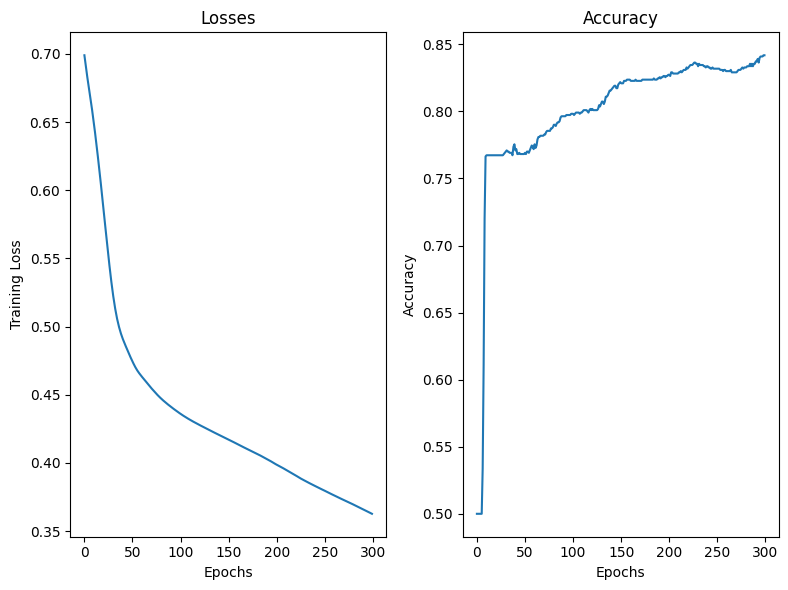

In [10]:
visualize_accuracy_n_loss(accuracy=accuracy, losses=losses)

In [11]:
y_proba = model(X_test)
y_proba = y_proba.detach().numpy()
y_pred = [int(val > 0.5) for val in y_proba]

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score


acc_score = accuracy_score(y_test.reshape(-1, 1), y_pred)
auc_score = roc_auc_score(y_test.reshape(-1, 1), y_pred)

In [13]:
acc_score, auc_score

(0.8353658536585366, 0.8270344827586207)